# Demo notebook for the Tropical Cyclones diagnostic

Before proceeding you should edit output file paths in `config_tcs_notebook.yml`

In [2]:
import pandas as pd
import numpy as np
import xarray as xr
import os
from tropical_cyclones import TCs, multi_plot
from aqua.util import load_yaml
from aqua.logger import log_configure
mainlogger = log_configure('WARNING', log_name='MAIN')

To run notebook with slurm

In [2]:
from aqua.slurm import slurm
slurm.job(cores=8, memory="50 GB", jobs=1, queue = "interactive", walltime='6:00:00')

2024-01-24 13:12:22 :: slurm :: WARNING  -> #!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p interactive
#SBATCH -A project_465000454
#SBATCH -n 1
#SBATCH --cpus-per-task=8
#SBATCH --mem=47G
#SBATCH -t 6:00:00
#SBATCH --error=./slurm/logs/dask-worker-%j.err
#SBATCH --output=./slurm/output/dask-worker-%j.out

/users/pghinass/mambaforge/aqua_common/bin/python3.1 -m distributed.cli.dask_worker tcp://193.167.209.166:41879 --nthreads 2 --nworkers 4 --memory-limit 11.64GiB --name dummy-name --nanny --death-timeout 60



Info on slurm job

In [3]:
slurm.squeue()

JOBID      CPUS  NODES ST         NAME                 TIME       START_TIME           DEPENDENCY           PARTITION            MIN_MEMORY          
5828203    8     1     PD         dask-worker          0:00       N/A                  (null)               interactive          94G                 
5835798    48    1     R          dask-worker          0:05       2024-01-22T15:53:37  (null)               interactive          47G                 


0

Get variables and other parameters from configuration file and store them in a dictionary. To change experiment and change tempest-extremes 
parameters and streaming options please see the config_tcs_notebook.yaml file in the same notebook dir and adjust it accordingly.

In [5]:
# load the config file
config = load_yaml('config_tcs_notebook.yaml')
config

{'dataset': {'model': 'IFS-NEMO', 'exp': 'historical-1990', 'source2d': 'hourly-hpz10-atm2d', 'source3d': 'hourly-hpz10-atm3d'}, 'paths': {'tmpdir': '/pfs/lustrep3/projappl/project_465000454/pghinassi/tc_analysis/tmpdir', 'fulldir': '/pfs/lustrep3/projappl/project_465000454/pghinassi/tc_analysis/fulldir', 'plotdir': '/pfs/lustrep3/projappl/project_465000454/pghinassi/tc_analysis/Figures/'}, 'setup': {'loglevel': 'WARNING'}, 'grids': {'lowgrid': 'r100', 'highgrid': 'r010'}, 'varlist': ['msl', '10u', '10v', 'mtpr'], 'time': {'startdate': '19900701', 'enddate': '19911231', 'frequency': '6h'}, 'stream': {'streamstep': '10D'}, 'detect': {'boxdim': 10}, 'stitch': {'n_days_freq': 30, 'n_days_ext': 2}, 'orography': {'file_path': '/users/pghinass/orography/IFS-NEMO/historical-1990/', 'file_name': 'orography_r100.nc'}}

Initialises the TCs class and calls the loop_streaming method which is a wrapper to retrieve data, prepare them, run DetectNodes and StitchNodes
and finally save the selected variables (defined in the config.yml file) with original model resolution along TCs tracks in a netcdf file.

In [4]:
# initialise tropical class with streaming options
tropical = TCs(tdict=config, streaming=True,
                stream_step=config['stream']['streamstep'],
                stream_startdate=config['time']['startdate'],
                paths=config['paths'],
                loglevel=config['setup']['loglevel'],
                orography=True,
                nproc=1)
tropical.loop_streaming(config)

2024-05-16 19:46:52 :: TCs :: WARNING  -> Model IFS-NEMO - Exp: historical-1990
2024-05-16 19:46:52 :: TCs :: WARNING  -> Initialised streaming for 10D days starting on 1990-07-01 00:00:00
2024-05-16 19:47:41 :: TCs :: WARNING  -> processing time step 19900701T00


[########################################] | 100% Completed | 93.51 ss


2024-05-16 19:50:40 :: TCs :: WARNING  -> processing time step 19900701T06


[########################################] | 100% Completed | 83.17 ss


2024-05-16 19:53:20 :: TCs :: WARNING  -> processing time step 19900701T12


[########################################] | 100% Completed | 76.44 ss


2024-05-16 19:55:52 :: TCs :: WARNING  -> processing time step 19900701T18


[#######                                 ] | 17% Completed | 1.51 s ms

Plot some variables following a track for a few time steps
First select a track file to open. Tracks files are contained in the $fulldir (see config file)
Select a start-end date for a period during which you want to plot variables

In [6]:
# at first select a track file to open. Tracks files are contained in the fulldir (see config file)

# select a start-end date for a period during which you want to plot variables

startend="19900829-19900927"
tracks_nc_file = os.path.join(config['paths']['fulldir'], f"{config['dataset']['model']}/{config['dataset']['exp']}/tempest_tracks_{startend}.nc")

# Example plot for variables contained in varlist:
for var in config['varlist']: 
    tracks_nc_file_var = xr.open_dataset(tracks_nc_file)[var]
    multi_plot(tracks_nc_file_var, config, save=False)

FileNotFoundError: [Errno 2] No such file or directory: '/pfs/lustrep3/projappl/project_465000454/pghinassi/tc_analysis/fulldir/IFS-NEMO-historical-1990/tempest_tracks_19900829-19900927.nc'

First select a track file to open. Tracks files are contained in the $fulldir (see config file)
select a start-end date for a period during which you want to plot variables

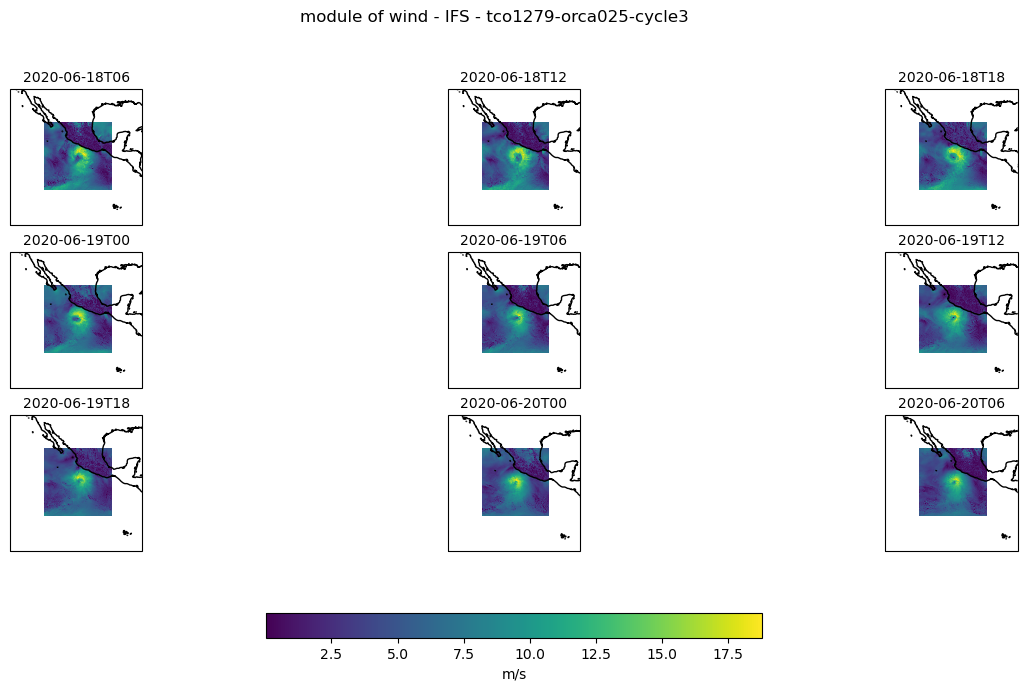

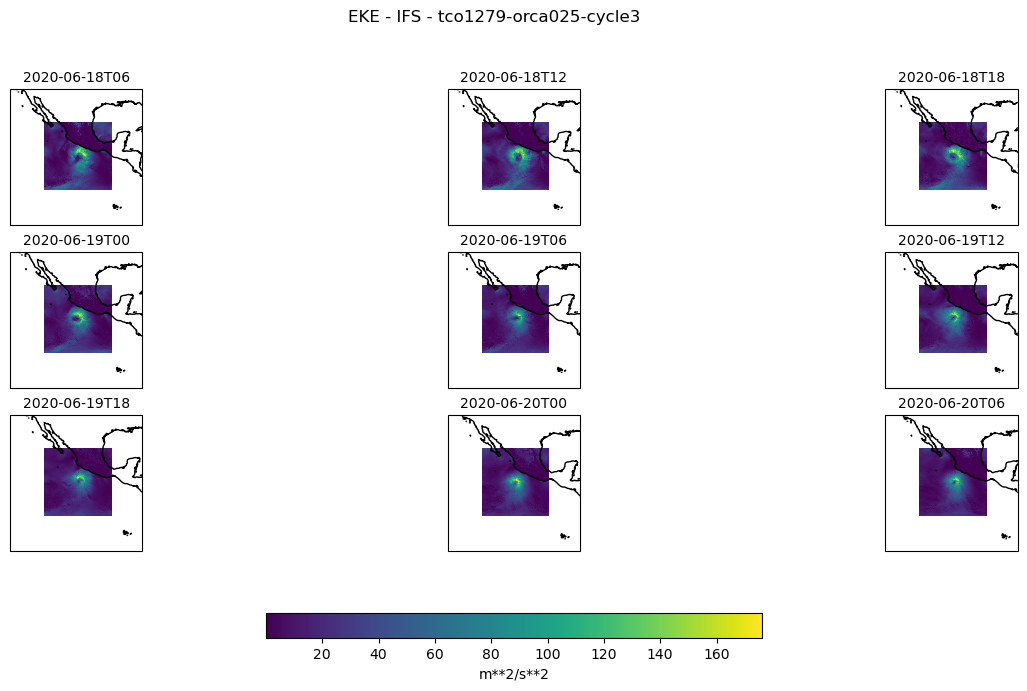

In [8]:


startend="20200618-20200717"
tracks_nc_file = os.path.join(tdict['paths']['fulldir'], f"{tdict['dataset']['model']}-{tdict['dataset']['exp']}/tempest_tracks_{startend}.nc")

# Example plot for module of wind and Eddy Kinetik Energy (EKE) (if 10u and 10v are available):

tracks_nc_file_u = xr.open_dataset(tracks_nc_file)["10u"]
tracks_nc_file_v = xr.open_dataset(tracks_nc_file)["10v"]

# module of wind
tracks_nc_file_uvmod = (tracks_nc_file_u**2 + tracks_nc_file_v**2)**0.5
multi_plot(tracks_nc_file_uvmod, tdict, title="module of wind", units="m/s")

# EKE
tracks_nc_file_EKE = 0.5*(tracks_nc_file_u**2 + tracks_nc_file_v**2)
multi_plot(tracks_nc_file_EKE, tdict, title="EKE", units="m**2/s**2")

Finally plot all TCs tracks found in the simulation

Getting trajectories from TempestExtremes file...
Running getTrajectories on '/home/b/b382216/scratch/tmpdir/IFS/tco1279-orca025-cycle3/tempest_tracks_tot.txt' with unstruc set to '0'
nVars set to 10 and headerDelimStr set to 'start'
Found 10 columns
Found 295 trajectories
... done reading data


/work/bb1153/b382216/mambaforge/envs/TCs/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/work/bb1153/b382216/mambaforge/envs/TCs/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecated. Please use .left_labels to toggle visibility instead.
  warnings.warn('The .ylabels_left attribute is deprecated. Please '


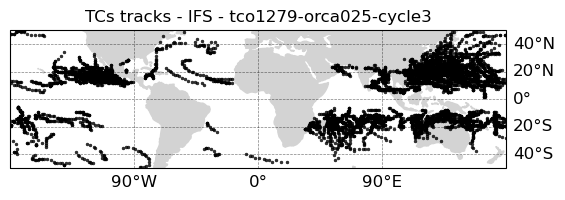

In [4]:
from glob import glob

filenames = sorted(glob(os.path.join(tdict['paths']['tmpdir'], tdict['dataset']['model'], tdict['dataset']['exp'], "tempest_track*.txt")))

with open(os.path.join(tdict['paths']['tmpdir'], tdict['dataset']['model'], tdict['dataset']['exp'], f"tempest_tracks_tot.txt"), 'w') as output_file:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                output_file.write(line)
tracks_file = os.path.join(tdict['paths']['tmpdir'], tdict['dataset']['model'], tdict['dataset']['exp'], "tempest_tracks_tot.txt")
plot_trajectories(tracks_file, tdict)